In [1]:
import eli5
import numpy as np
import pandas as pd
from sklearn.model_selection import KFold
from sklearn.linear_model import Ridge
from sklearn.pipeline import FeatureUnion
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics import mean_squared_log_error

In [2]:
train = pd.read_table('../data/train.tsv')

In [3]:
y_train = np.log1p(train['price'])
train['category_name'] = train['category_name'].fillna('Other').astype(str)
train['brand_name'] = train['brand_name'].fillna('missing').astype(str)
train['shipping'] = train['shipping'].astype(str)
train['item_condition_id'] = train['item_condition_id'].astype(str)
train['item_description'] = train['item_description'].fillna('None')

In [5]:
%%time

# we need a custom pre-processor to extract correct field,
# but want to also use default scikit-learn preprocessing (e.g. lowercasing)
default_preprocessor = CountVectorizer().build_preprocessor()
def build_preprocessor(field):
    field_idx = list(train.columns).index(field)
    return lambda x: default_preprocessor(x[field_idx])
    
vectorizer = FeatureUnion([
    ('name', CountVectorizer(
        min_df=10, stop_words='english',
        ngram_range=(1, 3),
        max_features=50000,
        preprocessor=build_preprocessor('name'))),
    ('category_name', CountVectorizer(
        token_pattern='.+',
        preprocessor=build_preprocessor('category_name'))),
    ('brand_name', CountVectorizer(
        token_pattern='.+',
        preprocessor=build_preprocessor('brand_name'))),
    ('shipping', CountVectorizer(
        token_pattern='\d+',
        preprocessor=build_preprocessor('shipping'))),
    ('item_condition_id', CountVectorizer(
        token_pattern='\d+',
        preprocessor=build_preprocessor('item_condition_id'))),
    ('item_description', TfidfVectorizer(
        ngram_range=(1, 3),
        max_features=100000,
        stop_words='english',
        preprocessor=build_preprocessor('item_description'))),
])
X_train = vectorizer.fit_transform(train.values)
X_train

CPU times: user 2min 55s, sys: 2.2 s, total: 2min 58s
Wall time: 2min 57s


In [6]:
%%time

def get_rmsle(y_true, y_pred):
    return np.sqrt(mean_squared_log_error(np.expm1(y_true), np.expm1(y_pred)))

cv = KFold(n_splits=10, shuffle=True, random_state=42)
for train_ids, valid_ids in cv.split(X_train):
    model = Ridge(
        solver='auto',
        fit_intercept=True,
        alpha=0.5,
        max_iter=100,
        normalize=False,
        tol=0.05)
    model.fit(X_train[train_ids], y_train[train_ids])
    y_pred_valid = model.predict(X_train[valid_ids])
    rmsle = get_rmsle(y_pred_valid, y_train[valid_ids])
    print(f'valid rmsle: {rmsle:.5f}')
    break

valid rmsle: 0.45754
CPU times: user 11.9 s, sys: 200 ms, total: 12.1 s
Wall time: 12.1 s


In [7]:
eli5.show_weights(model, vec=vectorizer)

Weight?,Feature
+2.971,<BIAS>
+1.923,item_description__limbs
+1.818,brand_name__david yurman
+1.728,item_description__carat
+1.719,item_description__14k
+1.642,name__dockatot
+1.572,item_description__64gb
+1.558,name__owlet
+1.509,item_description__500gb
+1.508,name__9300hailey


In [8]:
t = eli5.show_weights(model, vec=vectorizer)

In [15]:
df = eli5.show_weights_df(model, vec=vectorizer)

AttributeError: module 'eli5' has no attribute 'show_weights_df'

In [27]:
df = eli5.explain_weights_df(model, vec=vectorizer, feature_filter=lambda x: x != '<BIAS>')

In [28]:
df.head()

,target,feature,weight
0,y,item_description__limbs,1.923353
1,y,brand_name__david yurman,1.817555
2,y,item_description__carat,1.728474
3,y,item_description__14k,1.718538
4,y,name__dockatot,1.641718


In [29]:
df.shape

(155977, 3)

In [30]:
df['col_name'] = df['feature'].map(lambda x: x.split('__')[0])

In [31]:
df['col_val'] = df['feature'].map(lambda x: x.split('__')[1])

In [32]:
df.head()

,target,feature,weight,col_name,col_val
0,y,item_description__limbs,1.923353,item_description,limbs
1,y,brand_name__david yurman,1.817555,brand_name,david yurman
2,y,item_description__carat,1.728474,item_description,carat
3,y,item_description__14k,1.718538,item_description,14k
4,y,name__dockatot,1.641718,name,dockatot


In [33]:
df_n = df[df.weight < 0]

In [34]:
df_p = df[df.weight >= 0]

In [36]:
df_n

,target,feature,weight,col_name,col_val
82979,y,name__navy,-0.000005,name,navy
82980,y,item_description__power buttons,-0.000007,item_description,power buttons
82981,y,item_description__worn ships,-0.000011,item_description,worn ships
82982,y,item_description__air apple ipad,-0.000011,item_description,air apple ipad
82983,y,item_description__white sneakers,-0.000012,item_description,white sneakers
82984,y,item_description__silicone makeup sponge,-0.000012,item_description,silicone makeup sponge
82985,y,name__zumiez,-0.000012,name,zumiez
82986,y,brand_name__magnum,-0.000013,brand_name,magnum
82987,y,item_description__caused acne acne,-0.000014,item_description,caused acne acne
82988,y,item_description__pink bae,-0.000015,item_description,pink bae


In [38]:
df_n['col_name'].value_counts()

item_description     45487
name                 24024
brand_name            2743
category_name          739
item_condition_id        3
shipping                 2
Name: col_name, dtype: int64

In [40]:
n_name = []
n_item_desc = []
n_brand_name = []
n_category_name = []
n_item_condition_id = []
n_shipping = []

In [41]:
df_n_name = df_n[df_n.col_name == 'name']
df_n_item_desc = df_n[df_n.col_name == 'item_description']
df_n_brand_name = df_n[df_n.col_name == 'brand_name']
df_n_cat_name = df_n[df_n.col_name == 'category_name']

In [43]:
print(df_n_name.shape)
print(df_n_item_desc.shape)
print(df_n_brand_name.shape)
print(df_n_cat_name.shape)

(24024, 5)
(45487, 5)
(2743, 5)
(739, 5)


In [44]:
df_n_name.to_csv('../cache/n_name.csv', index=False)
df_n_item_desc.to_csv('../cache/n_item_desc.csv', index=False)
df_n_brand_name.to_csv('../cache/n_brand_name.csv', index=False)
df_n_cat_name.to_csv('../cache/n_cat_name.csv', index=False)

In [45]:
df_p_name = df_p[df_p.col_name == 'name']
df_p_item_desc = df_p[df_p.col_name == 'item_description']
df_p_brand_name = df_p[df_p.col_name == 'brand_name']
df_p_cat_name = df_p[df_p.col_name == 'category_name']

In [46]:
df_p_name

,target,feature,weight,col_name,col_val
4,y,name__dockatot,1.641718,name,dockatot
6,y,name__owlet,1.558040,name,owlet
8,y,name__9300hailey,1.508333,name,9300hailey
9,y,name__tieks,1.479318,name,tieks
13,y,name__hatchimal,1.425752,name,hatchimal
14,y,name__hatchimals,1.413714,name,hatchimals
15,y,name__tria,1.412262,name,tria
19,y,name__tyme,1.328259,name,tyme
20,y,name__dyson,1.308319,name,dyson
21,y,name__movado,1.307440,name,movado


In [64]:
 df_p_name['max_len'] = df_p_name["col_val"].map(lambda x: len(max(x.split(' '), key=len)))

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [65]:
import matplotlib as plt

In [66]:
df_p_name.head()

,target,feature,weight,col_name,col_val,max_len
4,y,name__dockatot,1.641718,name,dockatot,8
6,y,name__owlet,1.558040,name,owlet,5
8,y,name__9300hailey,1.508333,name,9300hailey,10
9,y,name__tieks,1.479318,name,tieks,5
13,y,name__hatchimal,1.425752,name,hatchimal,9


In [67]:
len(max('dockatot'.split(' '),key=len))

8

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f869690fb70>]], dtype=object)

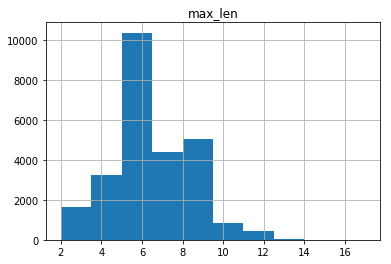

In [69]:
df_p_name.hist(column='max_len')
# plt.show()


In [70]:
df_p_name['num_words'] = df_p_name["col_val"].map(lambda x: sum([1 for w in x.split(' ')]))

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [71]:
df_p_name.head()

,target,feature,weight,col_name,col_val,max_len,num_words
4,y,name__dockatot,1.641718,name,dockatot,8,1
6,y,name__owlet,1.558040,name,owlet,5,1
8,y,name__9300hailey,1.508333,name,9300hailey,10,1
9,y,name__tieks,1.479318,name,tieks,5,1
13,y,name__hatchimal,1.425752,name,hatchimal,9,1


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f86ae960668>]], dtype=object)

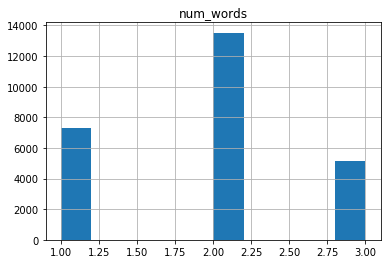

In [72]:
df_p_name.hist(column='num_words')

In [75]:
df_p_name_plus = df_p_name[df_p_name.weight >= 1.]

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f863554c978>]], dtype=object)

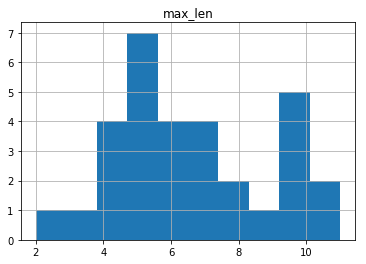

In [76]:
df_p_name_plus.hist(column='max_len')

In [77]:
df_p_name_plus.shape

(31, 7)

In [78]:
df_p_name.shape

(25976, 7)

In [79]:
df_p_name_1 = df_p_name[(df_p_name.max_len >= 4.) & (df_p_name.max_len <= 9.)]

In [80]:
df_p_name_1.shape

(23064, 7)

In [74]:
df_p_item_desc.head(50)

,target,feature,weight,col_name,col_val
0,y,item_description__limbs,1.923353,item_description,limbs
2,y,item_description__carat,1.728474,item_description,carat
3,y,item_description__14k,1.718538,item_description,14k
5,y,item_description__64gb,1.571714,item_description,64gb
7,y,item_description__500gb,1.509000,item_description,500gb
10,y,item_description__16gb,1.451910,item_description,16gb
11,y,item_description__pop stack,1.440614,item_description,pop stack
12,y,item_description__unlocked,1.437428,item_description,unlocked
17,y,item_description__32gb,1.371972,item_description,32gb
23,y,item_description__i5,1.290192,item_description,i5


In [ ]:
df_p_name['max_len'] = df_p_name["col_val"].map(lambda x: len(max(x.split(' '), key=len)))

In [81]:
df_p_item_desc['max_len'] = df_p_item_desc["col_val"].map(lambda x: len(max(x.split(' '), key=len)))

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f8692816358>]], dtype=object)

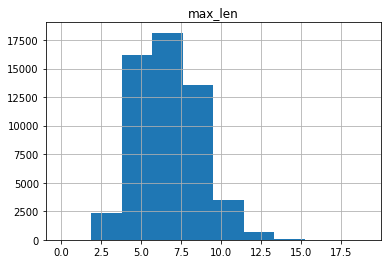

In [82]:
df_p_item_desc.hist(column='max_len')

In [83]:
df_p_cat_name['max_len'] = df_p_cat_name["col_val"].map(lambda x: len(max(x.split(' '), key=len)))

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f869d290630>]], dtype=object)

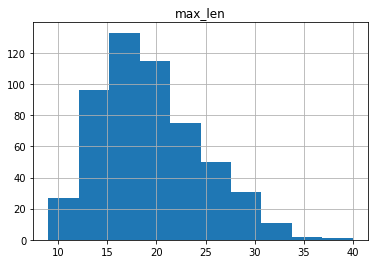

In [84]:
df_p_cat_name.hist(column='max_len')

In [85]:
df_p_cat_name.head()

,target,feature,weight,col_name,col_val,max_len
34,y,category_name__kids/strollers/lightweight,1.144794,category_name,kids/strollers/lightweight,26
71,y,category_name__kids/strollers/travel systems,0.990564,category_name,kids/strollers/travel systems,21
108,y,category_name__kids/strollers/standard,0.896068,category_name,kids/strollers/standard,23
112,y,"category_name__electronics/car audio, video & ...",0.885678,category_name,"electronics/car audio, video & gps/car subwoofers",15
122,y,category_name__other/musical instruments/wind ...,0.875416,category_name,other/musical instruments/wind & woodwind inst...,16
